# Expenses Urgency Prediction Notebook

## Install Required Libraries

In [1]:
!pip install pandas scikit-learn tensorflow matplotlib

## Import Libraries

In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from difflib import SequenceMatcher

## Data Processing

#### 1. Load dataset

In [3]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    urgency_map = {"Tingg1": 1, "Sedang": 2, "Rendah": 3}
    data["Urgensi"] = data["Urgensi"].replace(urgency_map).astype(int)
    return data

#### 2. Preprocess data

In [4]:
def preprocess_data(data):
    le = LabelEncoder()
    data["Kategori_Asli"] = data["Kategori"]  # Simpan kategori asli untuk pencocokan
    data["Kategori"] = le.fit_transform(data["Kategori"])  # Encode kategori
    scaler = MinMaxScaler()
    data["Jumlah_Normalized"] = scaler.fit_transform(data[["Jumlah"]])
    return data, le, scaler

## Build and Train Model

#### 3. Build and train model

In [6]:
def build_and_train_model(file_path, epochs=30, batch_size=32):
    # Load and preprocess data
    data = load_data(file_path)
    data, le, scaler = preprocess_data(data)

    # Prepare training and validation data
    X = data[["Jumlah_Normalized", "Kategori"]]
    y = data["Urgensi"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.summary()

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    # Plot training history
    plot_training_history(history)

    # Save and convert the model
    save_model(model)

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE Over Epochs')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

#### 4. Function to plot training history

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE Over Epochs')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

#### 5. Function to save the model

In [8]:
def save_model(model):
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

    # Save the model in .h5 format
    model.save(os.path.join(model_dir, 'predict_model.h5'))

    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the converted model as .tflite
    with open(os.path.join(model_dir, 'predict_model.tflite'), 'wb') as f:
        f.write(tflite_model)
    print("Model saved and converted successfully!")

#### 6. Main function to train and save model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 5.6234 - mean_absolute_error: 2.2060 - val_loss: 3.1199 - val_mean_absolute_error: 1.4248
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4890 - mean_absolute_error: 1.5891 - val_loss: 2.8849 - val_mean_absolute_error: 1.4827
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2978 - mean_absolute_error: 1.6137 - val_loss: 3.0985 - val_mean_absolute_error: 1.5991
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1289 - mean_absolute_error: 1.5862 - val_loss: 3.0329 - val_mean_absolute_error: 1.5812
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2697 - mean_absolute_error: 1.6110 - val_loss: 2.8834 - val_mean_absolute_error: 1.5299
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8296 - mean_absolute_error: 1.4712 - val_loss: 2.7167 - val_mean_absolute_error: 1.4578
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7670 - mean_absolute_error: 1.4320 - val_loss: 2.6294 - val_mea

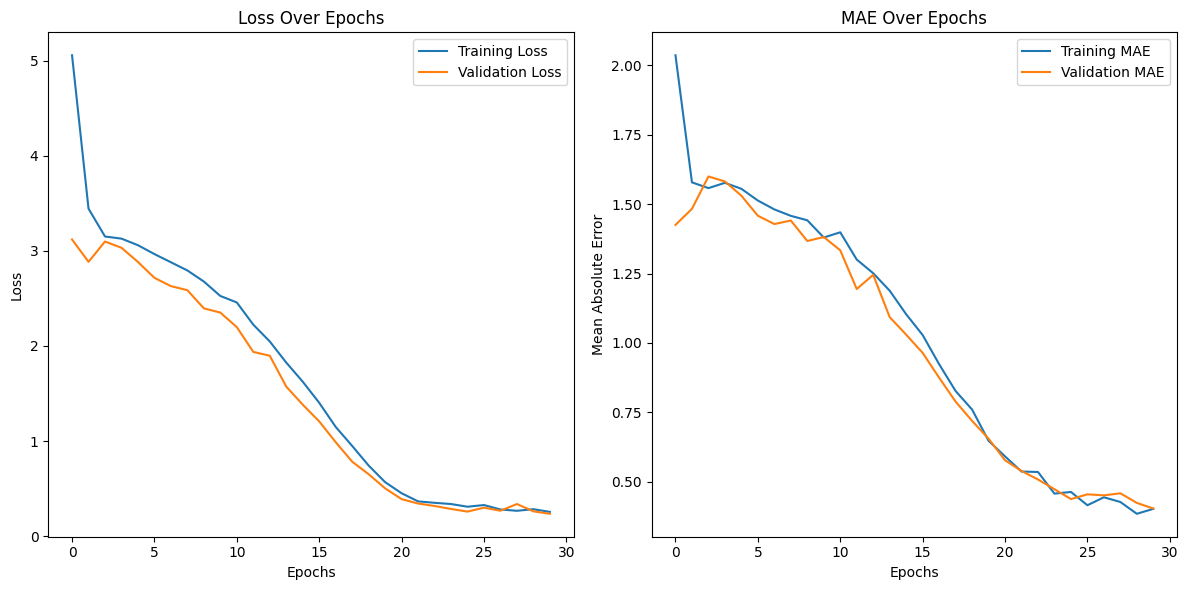

Saved artifact at '/tmp/tmpepnju7d9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor_110')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138661980123408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978938128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978938304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978937248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978935840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978932848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978943408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138661978935664: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved and converted successfully!
Model training and saving completed!


In [31]:
def train_model():
    file_path = "data/dataset.csv"
    model = build_and_train_model(file_path, epochs=30)
    print("Model training and saving completed!")

train_model()

## Predict urgency scores

#### 7. Function to Predict urgency scores

In [32]:
def predict_urgency(model, input_data, le, scaler):
    # Encode categories for prediction
    input_data["Kategori_Encoded"] = le.transform(input_data["Kategori"])
    input_data["Jumlah_Normalized"] = scaler.transform(input_data[["Jumlah"]])

    # Prepare features
    features = input_data[["Jumlah_Normalized", "Kategori_Encoded"]]

    # Predict urgency scores
    predictions = model.predict(features)
    input_data["Skor Urgensi"] = predictions

    # Map urgency scores to labels
    urgency_reverse_map = {1: "Tinggi", 2: "Sedang", 3: "Rendah"}

    # Determine urgency label based on rounded scores
    input_data["Label Urgensi"] = pd.Series(
        predictions.ravel().round().clip(1, 3).astype(int)
    ).map(urgency_reverse_map)

    # Sort data by urgency scores
    sorted_data = input_data.sort_values(by="Skor Urgensi", ascending=True).reset_index(drop=True)
    sorted_data["No"] = range(1, len(sorted_data) + 1)  # Add a numbering column

    # Return the results in a formatted table
    return sorted_data[["No", "Kategori_User", "Jumlah", "Skor Urgensi", "Label Urgensi"]]

## Handle User Input Categories

#### 8. Handle input categories with Pengeluaran + Kategori

In [33]:
def handle_input_category(input_category, dataset_categories):
    best_match = None
    best_ratio = 0.0

    # Pencocokan input pengguna dengan data kombinasi 'Pengeluaran + Kategori Asli'
    for pengeluaran, kategori_asli in zip(dataset_categories['Pengeluaran'], dataset_categories['Kategori_Asli']):
        combined_category = f"{pengeluaran} {kategori_asli}"  # Gabungkan Pengeluaran + Kategori Asli
        ratio = SequenceMatcher(None, input_category.lower(), combined_category.lower()).ratio()  # Case insensitive matching

        if ratio > best_ratio and ratio > 0.45:  # Ambil kecocokan terbaik di atas threshold
            best_match = kategori_asli
            best_ratio = ratio

    if best_match:
        print(f"Kategori ditemukan: '{best_match}', Ratio: {best_ratio:.2f}")
        return input_category, best_match  # Kategori asli ditemukan
    else:
        print(f"Kategori tidak ditemukan. Menggunakan input pengguna sebagai 'Lain lain', Ratio: {best_ratio:.2f}")
        return input_category, "Lain lain"  # Kategori backend "Lain lain", tetapi tampilkan input asli pengguna

## Load and Use the Model

#### 9. Function to load the pre-trained model

In [29]:
def load_model():
    model_path = 'models/predict_model.h5'
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully!")
        return model
    else:
        print("Model not found. Please train the model first.")
        exit()

## Main function to predict

In [35]:
model = load_model()
data = load_data("data/dataset.csv")
data, le, scaler = preprocess_data(data)

input_data = []  # Initialize an empty list to store input data
print("===== Prediksi Urgensi Pengeluaran =====")
while True:
    kategori = input("Masukkan kategori: ")
    jumlah = input("Masukkan nominal: ")

    try:
        jumlah = float(jumlah)  # Convert the amount to float
        kategori_user, kategori_backend = handle_input_category(kategori, data[['Pengeluaran', 'Kategori_Asli']])
        input_data.append({"Kategori_User": kategori_user, "Kategori": kategori_backend, "Jumlah": jumlah})
    except ValueError:
        print("Jumlah harus berupa angka. Coba lagi.")

    tambah = input("Tambah pengeluaran lain? (y/n): ").lower()
    if tambah != 'y':
        break

# Create DataFrame from user input
input_data = pd.DataFrame(input_data)

# Predict urgency
results = predict_urgency(model, input_data, le, scaler)

# Display results with formatted columns
print("===== Hasil Prediksi =====")
print(results.rename(columns={"Kategori_Asli": "Kategori"}).to_string(index=False))

Model loaded successfully!
===== Prediksi Urgensi Pengeluaran =====
Masukkan kategori: tagihan
Masukkan nominal: 300000
Kategori ditemukan: 'Tagihan', Ratio: 0.70
Tambah pengeluaran lain? (y/n): y
Masukkan kategori: belanja
Masukkan nominal: 180000
Kategori ditemukan: 'Belanja', Ratio: 0.64
Tambah pengeluaran lain? (y/n): y
Masukkan kategori: pendidikan
Masukkan nominal: 750000
Kategori ditemukan: 'Pendidikan', Ratio: 0.83
Tambah pengeluaran lain? (y/n): y
Masukkan kategori: donasi
Masukkan nominal: 50000
Kategori ditemukan: 'Donasi', Ratio: 0.63
Tambah pengeluaran lain? (y/n): n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
===== Hasil Prediksi =====
 No Kategori_User   Jumlah  Skor Urgensi Label Urgensi
  1       tagihan 300000.0      1.493127        Tinggi
  2    pendidikan 750000.0      1.533232        Sedang
  3       belanja 180000.0      2.880723        Rendah
  4        donasi  50000.0      2.918346        Rendah
